In [1]:
import os
import numpy as np

from astropy.io.fits import getdata
from astropy import wcs
from astropy.io import fits
from astropy import units as u
from astropy import constants as con
from astropy.coordinates import SkyCoord

import matplotlib
import matplotlib.pyplot as plt
import matplotlib as mpl
import matplotlib

import aplpy

import math
from scipy.interpolate import interp1d

#matplotlib.use('PDF')

from __future__ import print_function
from scipy.optimize import curve_fit

deg_to_rad = 0.0174533
rad_to_deg = 57.2958
arcsec_to_arcmin = 0.0166667

## Step 1: sampling the dispersion function data 

In [2]:
# Importing JVLA PA file
PAmap = 'G31p4_Qband_D.rob2.PA.image.tt0.miriad.dropdeg.fits'
intensity_scale = 1.0
if_success = False
try:

    # importing FITS image to a HDU
    PAhdu = fits.open(PAmap)

    # editing the FITS image by multiplying a scaling factor
    PAhdu[0].data = PAhdu[0].data * intensity_scale

    if_success = True

except:
    print('Unable to read the PA FITS image. Please double check the image file.')
    print(PAmap)

if (if_success == True):
    # Reading FITS header
    try:
        naxis1 = PAhdu[0].header['naxis1']
        naxis2 = PAhdu[0].header['naxis2']
        crval1 = PAhdu[0].header['crval1']
        crpix1 = PAhdu[0].header['crpix1']
        cdelt1 = PAhdu[0].header['cdelt1']
        crval2 = PAhdu[0].header['crval2']
        crpix2 = PAhdu[0].header['crpix2']
        cdelt2 = PAhdu[0].header['cdelt2']
        hduwcs = wcs.WCS(PAhdu[0].header)
    except:
        print('Warning. No coordinate headers')

    try:
        bmaj = PAhdu[0].header['bmaj']
        bmin = PAhdu[0].header['bmin']
        bpa = PAhdu[0].header['bpa']
        print("bmaj is", bmaj)
    except:
        print('Warnning. No header for synthesized beam size')

bmaj is 0.0007631573244


Set OBSGEO-B to    34.078827 from OBSGEO-[XYZ].
Set OBSGEO-H to     2115.607 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]


In [3]:
# Importing JVLA PI file (for calculating the effective cloud depth)
PImap = 'G31p4_Qband_D.rob2.PI.image.tt0.miriad.dropdeg.fits'
intensity_scale = 1.0
if_success = False
try:

    # importing FITS image to a HDU
    PIhdu = fits.open(PImap)

    # editing the FITS image by multiplying a scaling factor
    PIhdu[0].data = PIhdu[0].data * intensity_scale

    if_success = True

except:
    print('Unable to read the PA FITS image. Please double check the image file.')
    print(PImap)

if (if_success == True):
    # Reading FITS header
    try:
        PInaxis1 = PIhdu[0].header['naxis1']
        PInaxis2 = PIhdu[0].header['naxis2']
        PIcrval1 = PIhdu[0].header['crval1']
        PIcrpix1 = PIhdu[0].header['crpix1']
        PIcdelt1 = PIhdu[0].header['cdelt1']
        PIcrval2 = PIhdu[0].header['crval2']
        PIcrpix2 = PIhdu[0].header['crpix2']
        PIcdelt2 = PIhdu[0].header['cdelt2']
        PIhduwcs = wcs.WCS(PIhdu[0].header)
    except:
        print('Warning. No coordinate headers')

    try:
        PIbmaj = PIhdu[0].header['bmaj']
        PIbmin = PIhdu[0].header['bmin']
        PIbpa = PIhdu[0].header['bpa']
        print("PI_bmaj is", PIbmaj)
    except:
        print('Warnning. No header for synthesized beam size')

PI_bmaj is 0.0007631573244


In [4]:
xlower = 221
ylower = 223
xupper = 260
yupper = 262
PAcenter = []

#PA = PAhdu[0].data

# selecting PA only in the center region and putting them in a 1D array PAcenter
for x in range(xlower, xupper, 1):
    for y in range(ylower, yupper, 1):
        PA_JVLA = PAhdu[0].data[x][y]
        PAcenter.append(PA_JVLA)

# turning the list into an numpy array so we can use isnan to filter out the nan values
PAcenter = np.array([PAcenter])
PAcenter = PAcenter[~np.isnan(PAcenter)]

In [5]:
PAcenter4 = []
PAcenter4_nonan = [] # the array used to calculate Houde 

# selecting PA only in the center region and putting them in a 3D array PAcenter; 
# [i][0] is the x coordinate, [i][1] is the y coordinate, [i][2] is the PA value 
for x in range(xlower, xupper, 1):
    for y in range(ylower, yupper, 1):
        PA_JVLA4 = [x, y, PAhdu[0].data[x][y]]
        PAcenter4.append(PA_JVLA4)  

# turning the list into an numpy array so we can use isnan to filter out the nan values
for i in range(len(PAcenter4)):
    if math.isnan(PAcenter4[i][2]) == False:
        PA_JVLA4_nonan = [PAcenter4[i][0], PAcenter4[i][1], PAcenter4[i][2]]
        PAcenter4_nonan.append(PA_JVLA4_nonan)

# Outputting to data file just for checking  
outputFile1 = open("houde_array_nonan.tab", "w")

for i in range(len(PAcenter4_nonan)):
    print(PAcenter4_nonan[i][0], PAcenter4_nonan[i][1], PAcenter4_nonan[i][2], sep='\t', file=outputFile1)

outputFile1.close()    

In [6]:
# Main point: producing ell and the corresponding deltaPA and putting them into a 1D array
# 1D array so it is easier to bin them later using fucntions like np.histogram

deltaPA = []
ell_pixel = []
ell_arcsec = []
PA_vs_ellarcsec = []
pixel_size = 0.2983 # arcsecond

for i in range(len(PAcenter4_nonan)):
    # returning these holder list to zero for every target pixel
    sublistPA = []
    sublistellpixel = []
    sublistellarcsec = []
    for j in range(i+1, len(PAcenter4_nonan), 1):
        # delta PA constrained to [0, 90] deg 
        deltaPAij = abs(PAcenter4_nonan[j][2] - PAcenter4_nonan[i][2])
        if deltaPAij > 90 or deltaPAij == 90:
            deltaPAij = 180 - deltaPAij        
        sublistPA.append(deltaPAij)
        
        # distance in pixel between 2 pixels 
        ell_pixelij = np.sqrt((PAcenter4_nonan[i][0]-PAcenter4_nonan[j][0])**2 + (PAcenter4_nonan[i][1]-PAcenter4_nonan[j][1])**2)
        sublistellpixel.append(ell_pixelij)
        
        # distance in arcsecond between 2 pixels
        ell_arcsecij = ell_pixelij * pixel_size
        sublistellarcsec.append(ell_arcsecij)
        
        # putting all the deltaPA values with their corresponding ell into a 2D array
        # where PA_vs_ellpixel[k][0] is ell in arcsec and PA_vs_ellpixel[k][1] is the deltaPA 
        sublistellvsPA = [ell_arcsecij, deltaPAij, np.cos(deltaPAij*deg_to_rad)]
        PA_vs_ellarcsec.append(sublistellvsPA)
        
    # back to to i loop    
    deltaPA.append(sublistPA)
    ell_pixel.append(sublistellpixel)
    ell_arcsec.append(sublistellarcsec)

# output delta PA into data file 
outputFile2 = open("deltaPA2.tab", "w")
for i in range(len(deltaPA)):
    print(deltaPA[i], sep='\t', file=outputFile2)
outputFile2.close()  

# output distance in pixel into data file 
outputFile3 = open("ell_pixel.tab", "w")
for i in range(len(ell_pixel)):
    print(ell_pixel[i], sep='\t', file=outputFile3)
outputFile3.close()  

# output distance in arcsecond into data file 
outputFile4 = open("ell_arcsec.tab", "w")
for i in range(len(ell_arcsec)):
    print(ell_arcsec[i], sep='\t', file=outputFile4)
outputFile4.close()  

# output distance in arcsecond into data file 
outputFile5 = open("PA_vs_ellarcsec.tab", "w")
for i in range(len(PA_vs_ellarcsec)):
    print(PA_vs_ellarcsec[i], sep='\t', file=outputFile5)
outputFile5.close()  

In [7]:
# Binning the data into bins of ell_k 

PA_vs_ellarcsec_arr = np.asarray(PA_vs_ellarcsec)
count4, bin4 = np.histogram(PA_vs_ellarcsec_arr[:, 0], bins = 60)
#print(bin4)
#print(count4)

cos_deltaPA_bin = []

for index in range(len(bin4)):
    sublist_cos_deltaPA_bin = []
    if index < (len(bin4)-2): 
        for i in range(len(PA_vs_ellarcsec)):
            if (PA_vs_ellarcsec[i][0] > bin4[index] or PA_vs_ellarcsec[i][0] == bin4[index]) and PA_vs_ellarcsec[i][0] < bin4[index+1]:
                sublist_cos_deltaPA_bin.append(PA_vs_ellarcsec[i][2])
        #print(bin4[index], len(sublist_cos_deltaPA_bin))        
        cos_deltaPA_bin.append(sublist_cos_deltaPA_bin)
    
    if index == (len(bin4)-2): 
        for i in range(len(PA_vs_ellarcsec)):
            if (PA_vs_ellarcsec[i][0] > bin4[index] or PA_vs_ellarcsec[i][0] == bin4[index]) and (PA_vs_ellarcsec[i][0] < bin4[index+1] or PA_vs_ellarcsec[i][0] == bin4[index]):
                sublist_cos_deltaPA_bin.append(PA_vs_ellarcsec[i][2])
        #print(bin4[index], len(sublist_cos_deltaPA_bin)) 
        cos_deltaPA_bin.append(sublist_cos_deltaPA_bin)

# At the end, cos_deltaPA_bin contains 9 rows and each row contians differnt number of element, depending on the count in each bin
# Each row represents the left edge of each bin

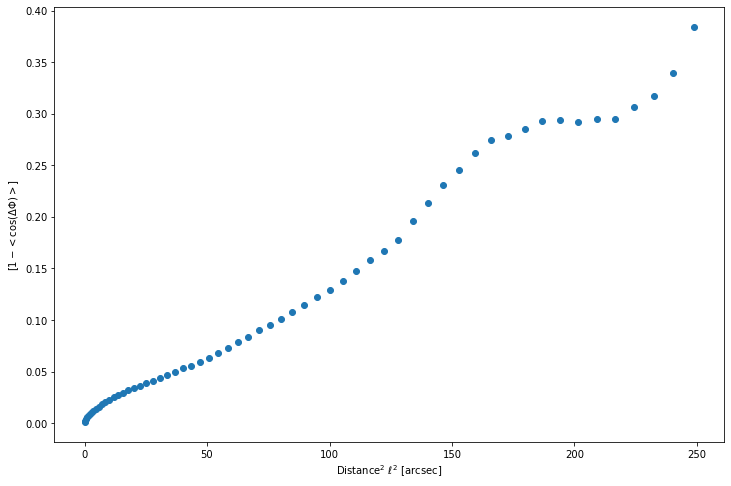

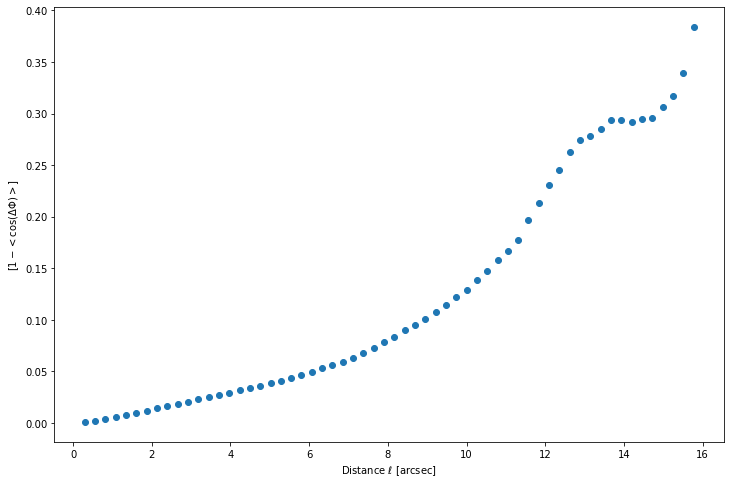

In [8]:
avg_cos_deltaPA = []
for i in range(len(cos_deltaPA_bin)):
    sublist_avg_cos_deltaPA = [bin4[i], np.mean(cos_deltaPA_bin[i])]
    avg_cos_deltaPA.append(sublist_avg_cos_deltaPA)
    
outputFile6 = open("avg_cos_deltaPA_vs_ell.tab", "w")
for i in range(len(avg_cos_deltaPA)):
    print(avg_cos_deltaPA[i], sep='\t', file=outputFile6)
outputFile6.close()  

avg_cos_deltaPA_plot = []
for i in range(len(cos_deltaPA_bin)):
    avg_cos_deltaPA_plot.append(1.0 - avg_cos_deltaPA[i][1])
#print(avg_cos_deltaPA_plot)

ell_plot = np.asarray(avg_cos_deltaPA)[:, 0]
#print(ell_plot)

ell2_plot = ell_plot**2

fig = plt.figure(figsize=(12,8))
plt.xlabel(r'$ \mathrm{Distance}^2\/\/ \ell^2\/\/ [\mathrm{arcsec}]$')
plt.ylabel(r'$[1 - <\mathrm{cos}(\Delta \Phi)>]$')
plt.scatter(ell2_plot, avg_cos_deltaPA_plot)
plt.show() 

fig = plt.figure(figsize=(12,8))
plt.xlabel(r'$ \mathrm{Distance}\/\/ \ell\/\/ [\mathrm{arcsec}]$')
plt.ylabel(r'$[1 - <\mathrm{cos}(\Delta \Phi)>]$')
plt.scatter(ell_plot, avg_cos_deltaPA_plot)
plt.show() 

## Step 2: Finding effective cloud depth 

In [9]:
PIcenter4 = []
PIcenter4_nonan = [] # the array used to calculate Houde 

# selecting PI only in the center region and putting them in a 3D array PIcenter; 
# [i][0] is the x coordinate, [i][1] is the y coordinate, [i][2] is the PI value 
for x in range(xlower, xupper, 1):
    for y in range(ylower, yupper, 1):
        PI_JVLA4 = [x, y, PIhdu[0].data[x][y]]
        PIcenter4.append(PI_JVLA4)  

# turning the list into an numpy array so we can use isnan to filter out the nan values
for i in range(len(PIcenter4)):
    if math.isnan(PIcenter4[i][2]) == False:
        PI_JVLA4_nonan = [PIcenter4[i][0], PIcenter4[i][1], PIcenter4[i][2]]
        PIcenter4_nonan.append(PI_JVLA4_nonan)
        
outputFile7 = open("houde_PI_array_nonan.tab", "w")

for i in range(len(PIcenter4_nonan)):
    print(PIcenter4_nonan[i][0], PIcenter4_nonan[i][1], PIcenter4_nonan[i][2], sep='\t', file=outputFile7)

outputFile7.close()   

In [10]:
PI_square = []
PI_ell_pixel = []
PI_ell_arcsec = []
PI_vs_ellarcsec = []
#pixel_size = 0.2983 # arcsecond

for i in range(len(PIcenter4_nonan)):
    # returning these holder list to zero for every target pixel
    sublistPI = []
    sublist_PIellpixel = []
    sublist_PIellarcsec = []
    for j in range(i, len(PIcenter4_nonan), 1):
        # P^2(l) = P(r)P(r+l) 
        deltaPIij = PIcenter4_nonan[j][2]*PIcenter4_nonan[i][2]      
        sublistPI.append(deltaPIij)
        
        # distance in pixel between 2 pixels 
        PI_ell_pixelij = np.sqrt((PIcenter4_nonan[i][0]-PIcenter4_nonan[j][0])**2 + (PIcenter4_nonan[i][1]-PIcenter4_nonan[j][1])**2)
        sublist_PIellpixel.append(PI_ell_pixelij)
        
        # distance in arcsecond between 2 pixels
        PI_ell_arcsecij = PI_ell_pixelij * pixel_size
        sublist_PIellarcsec.append(PI_ell_arcsecij)
        
        # putting all the PI^2 values with their corresponding ell into a 2D array
        # where PI_vs_ellarcsec[k][0] is ell in arcsec and PI_vs_ellarcsec[k][1] is the PI^2 
        sublistellvsPI = [PI_ell_arcsecij, deltaPIij]
        PI_vs_ellarcsec.append(sublistellvsPI)
        
    # back to to i loop    
    PI_square.append(sublistPI)
    PI_ell_pixel.append(sublist_PIellpixel)
    PI_ell_arcsec.append(sublist_PIellarcsec)

In [21]:
# Binning the data into bins of ell_k 
PI_vs_ellarcsec_arr = np.asarray(PI_vs_ellarcsec)
count41, bin41 = np.histogram(PI_vs_ellarcsec_arr[:, 0], bins = 10)
#print(bin41)
#print(count41)

P_sqaure_bin = []

for index in range(len(bin41)):
    sublist_P_sqaure_bin = []
    if index < (len(bin41)-2): 
        for i in range(len(PI_vs_ellarcsec)):
            if (PI_vs_ellarcsec[i][0] > bin41[index] or PI_vs_ellarcsec[i][0] == bin41[index]) and PI_vs_ellarcsec[i][0] < bin41[index+1]:
                sublist_P_sqaure_bin.append(PI_vs_ellarcsec[i][1])
        #print(bin41[index], len(sublist_P_sqaure_bin))        
        P_sqaure_bin.append(sublist_P_sqaure_bin)
    
    if index == (len(bin41)-2): 
        for i in range(len(PI_vs_ellarcsec)):
            if (PI_vs_ellarcsec[i][0] > bin41[index] or PI_vs_ellarcsec[i][0] == bin41[index]) and (PI_vs_ellarcsec[i][0] < bin41[index+1] or PI_vs_ellarcsec[i][0] == bin41[index]):
                sublist_P_sqaure_bin.append(PI_vs_ellarcsec[i][1])
        #print(bin41[index], len(sublist_P_sqaure_bin)) 
        P_sqaure_bin.append(sublist_P_sqaure_bin)

# At the end, cos_deltaPA_bin contains 9 rows and each row contians differnt number of element, depending on the count in each bin
# Each row represents the left edge of each bin

Like in Houde 2009, the distance corresponding to half of the correlation function is taken arbitarily to be the effective cloud depth
The effective cloud depth is 9.8 arcsec, the coressponding normalized PI correlation function is  0.5072664667308873


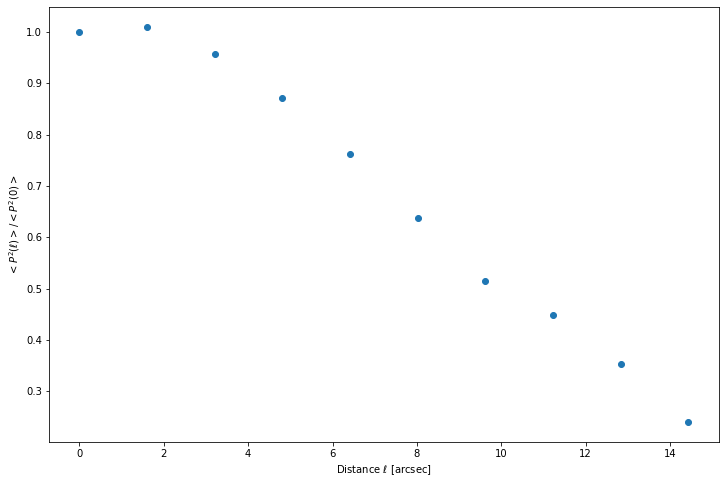

In [22]:
avg_P_sqaure = []
for i in range(len(P_sqaure_bin)):
    sublist_avg_P_sqaure = [bin41[i], np.mean(P_sqaure_bin[i])]
    avg_P_sqaure.append(sublist_avg_P_sqaure)

avg_P_sqaure_ratio = []
for i in range(len(avg_P_sqaure)):
    avg_P_sqaure_ratio.append(avg_P_sqaure[i][1]/avg_P_sqaure[0][1])
#print(avg_P_sqaure_ratio)

PI_ell_plot = np.asarray(avg_P_sqaure)[:, 0]
#print(PI_ell_plot)

# Finding the distance corresponding to ratio = 0.5
f = interp1d(PI_ell_plot, avg_P_sqaure_ratio)
trial_distance = 9.8
ratio = f(trial_distance)
print("Like in Houde 2009, the distance corresponding to half of the correlation function is taken arbitarily to be the effective cloud depth")
print("The effective cloud depth is", trial_distance, "arcsec, the coressponding normalized PI correlation function is ", ratio)
    
fig = plt.figure(figsize=(12,8))
plt.xlabel(r'$ \mathrm{Distance}\/\/ \ell\/\/ [\mathrm{arcsec}]$')
plt.ylabel(r'$<P^2(\ell)>/<P^2(0)>$')
plt.scatter(PI_ell_plot, avg_P_sqaure_ratio)
plt.show() 

## Step 3: Fitting dispersion funtion to get angular dispersion

### 3.1 Directly fitting all 3 parameters without bound --> RuntimeError

In [13]:
# extracting only the first 15 data points of the dispersion fucntion to do fitting 
ell_fit = ell2_plot[:15]
avg_cos_deltaPA_fit = avg_cos_deltaPA_plot[:15]

W = (2.747+1.617)/2.0 # beam "radius"
Delta_prime = trial_distance # effective cloud depth; 9.8 arcsec

def correlation_func(ell2, delta, PAdispersion4, a_2_prime):
    correlation = np.sqrt(2*np.pi)*PAdispersion4*((delta**3)/((delta**2+2*W**2)*Delta_prime))*(1-np.exp((-ell2)/(2*(delta**2+2*W**2))))+a_2_prime*(ell2)
    return correlation

# simultaneously fitting all 3 parameters
parameters, covariance = curve_fit(correlation_func, ell_fit, avg_cos_deltaPA_fit)

fit_delta = parameters[0]
fit_PAdispersion4 = parameters[1]
fit_a_2_prime = parameters[2]

print("The sqaure of PA dispersion is fitted to be", fit_PAdispersion4)
print("delta is fitted to be", fit_delta)
print("a' is fitted to be", fit_a_2_prime)

correlation_func_fit = correlation_func(ell2_plot[:15], fit_delta, fit_PAdispersion4, fit_a_2_prime)
fig = plt.figure(figsize=(12,4))
plt.xlabel(r'$ \mathrm{Distance}^2\/\/ \ell^2\/\/ [\mathrm{arcsec^2}]$')
plt.ylabel(r'$[1 - <\mathrm{cos}(\Delta \Phi)>]$')
plt.scatter(ell_fit, avg_cos_deltaPA_fit)
plt.plot(ell_fit, correlation_func_fit, '-')
plt.show() 

RuntimeError: Optimal parameters not found: Number of calls to function has reached maxfev = 800.

### 3.2 Directly fitting all 3 parameters with arbitrary bound

The beam radius is 2.182 arcsecond
The sqaure of PA dispersion is fitted to be 2.999999996196478
delta is fitted to be 0.9259742607211406
a' is fitted to be 8.179195207777077e-11


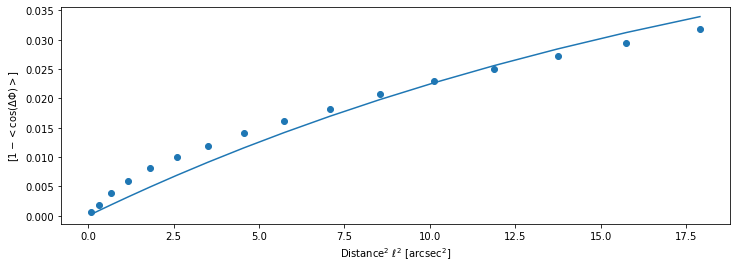

In [31]:
# extracting only the first 15 data points of the dispersion fucntion to do fitting 
ell_fit = ell2_plot[:16]
avg_cos_deltaPA_fit = avg_cos_deltaPA_plot[:16]

W = (2.747+1.617)/2.0 # beam "radius"
Delta_prime = trial_distance # effective cloud depth; 9.8 arcsec
print("The beam radius is", W, "arcsecond")

def correlation_func(ell2, delta, PAdispersion4, a_2_prime):
    correlation = np.sqrt(2*np.pi)*PAdispersion4*((delta**3)/((delta**2+2*W**2)*Delta_prime))*(1-np.exp((-ell2)/(2*(delta**2+2*W**2))))+a_2_prime*(ell2)
    return correlation

# simultaneously fitting all 3 parameters
parameters, covariance = curve_fit(correlation_func, ell_fit, avg_cos_deltaPA_fit, bounds=([0, 0, 0], [3., 3., 3.]))

fit_delta = parameters[0]
fit_PAdispersion4 = parameters[1]
fit_a_2_prime = parameters[2]

print("The sqaure of PA dispersion is fitted to be", fit_PAdispersion4)
print("delta is fitted to be", fit_delta)
print("a' is fitted to be", fit_a_2_prime)

correlation_func_fit = correlation_func(ell_fit, fit_delta, fit_PAdispersion4, fit_a_2_prime)
fig = plt.figure(figsize=(12,4))
plt.xlabel(r'$ \mathrm{Distance}^2\/\/ \ell^2\/\/ [\mathrm{arcsec^2}]$')
plt.ylabel(r'$[1 - <\mathrm{cos}(\Delta \Phi)>]$')
plt.scatter(ell_fit, avg_cos_deltaPA_fit)
plt.plot(ell_fit, correlation_func_fit, '-')
plt.show() 

<font size="3">
Comment: <br>
The bound is set to be 0 to 3. The 3 parameters must be positive, hence the lower bound. The upper bound is entirely arbitrary but the fitting doesn't seem so bad. So I keep it here. 
</font>

### 3.3 Fitting the slope first to constraint a^2', then fit the remaining 2 parameters

The slope is fitted to be 0.0011170176914795588
The x-intercept is fitted to be 0.011822667538792056


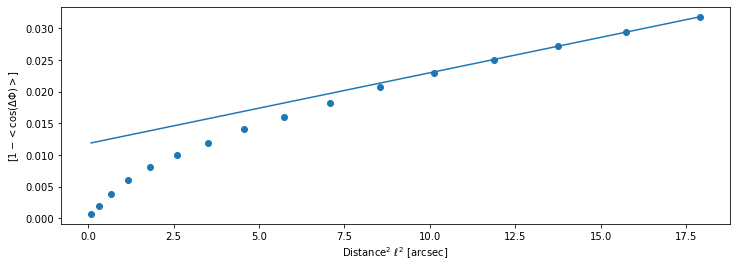

In [17]:
# extracting only the linear parts of the dispersion fucntion to do lienar fitting 
ell_linear_fit = ell2_plot[12:16]
avg_cos_deltaPA_linear_fit = avg_cos_deltaPA_plot[12:16]

def linear_fuc(ell2, a_2_prime, c):
    linear = a_2_prime*ell2 + c
    return linear

parameters, covariance = curve_fit(linear_fuc, ell_linear_fit, avg_cos_deltaPA_linear_fit)

fit_slope = parameters[0]
fit_intercept = parameters[1]

print("The slope is fitted to be", fit_slope)
print("The x-intercept is fitted to be", fit_intercept)

linear_fuc_fit = linear_fuc(ell_fit, fit_slope, fit_intercept)
fig = plt.figure(figsize=(12,4))
plt.xlabel(r'$ \mathrm{Distance}^2\/\/ \ell^2\/\/ [\mathrm{arcsec}]$')
plt.ylabel(r'$[1 - <\mathrm{cos}(\Delta \Phi)>]$')
plt.scatter(ell_fit, avg_cos_deltaPA_fit)
plt.plot(ell_fit, linear_fuc_fit, '-')
plt.show() 

The sqaure of PA dispersion is fitted to be 0.22115320080219156
delta is fitted to be 2.0000000000000004


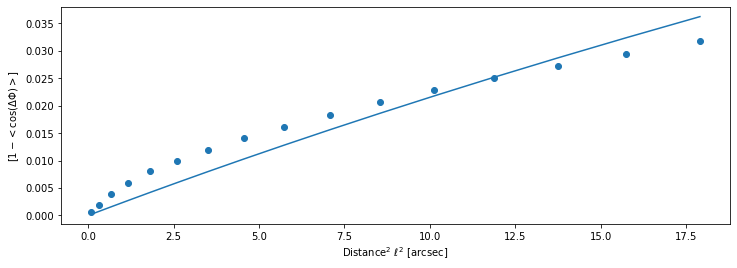

In [32]:
# use the value of a' in linear fit above to give more constraints to the fits
Delta_prime = trial_distance # 9.8 arcsec
a_2_prime = fit_slope

def correlation_func(ell2, delta, PAdispersion4):
    correlation = np.sqrt(2*np.pi)*PAdispersion4*((delta**3)/((delta**2+2*W**2)*Delta_prime))*(1-np.exp((-ell2)/(2*(delta**2+2*W**2))))+a_2_prime*(ell2)
    return correlation

# ell2_plot_fit = ell2_plot[:5]
# print(ell2_plot_fit)
parameters, covariance = curve_fit(correlation_func, ell_fit, avg_cos_deltaPA_fit, bounds=([2, 0], [9, 5]))

fit_delta = parameters[0]
fit_PAdispersion4 = parameters[1]

print("The sqaure of PA dispersion is fitted to be", fit_PAdispersion4)
print("delta is fitted to be", fit_delta)

correlation_func_fit = correlation_func(ell_fit, fit_delta, fit_PAdispersion4)
fig = plt.figure(figsize=(12,4))
plt.xlabel(r'$ \mathrm{Distance}^2\/\/ \ell^2\/\/ [\mathrm{arcsec}]$')
plt.ylabel(r'$[1 - <\mathrm{cos}(\Delta \Phi)>]$')
plt.scatter(ell_fit, avg_cos_deltaPA_fit)
plt.plot(ell_fit, correlation_func_fit, '-')
plt.show() 

<font size="3">
Comment:<br>
the turbulent correlation length is constrained to be between the beam radius and the effective cloud depth. The square of the angular dispersion is constrained arbitrarily. This is the method with the most reasonable constraints but the fitting is not so good. The linear part seems to be overpowering the exponential part at small distance. 
</font>